In [56]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json
%matplotlib inline
from sklearn.grid_search import GridSearchCV

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?
- These are websites that always relevant like recipies or reviews (as opposed to current events)
- Look at some examples

In [3]:
data = pd.read_csv('../../assets/datasets/train.tsv', sep='\t', na_values='?')

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', '')).fillna('')
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', '')).fillna('')

In [4]:
data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


#### In previous lessons, we added text features manually as below 

In [5]:
data['recipe'] = data['title'].str.lower().str.contains('recipe')
data['electronic'] = data['title'].str.lower().str.contains('electronic')
data['tips'] = data['title'].str.lower().str.contains('tips')

In [6]:
data[['title','recipe','electronic','tips','label']].head()

,title,recipe,electronic,tips,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",False,False,False,0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",False,True,False,1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,False,False,False,1
3,10 Foolproof Tips for Better Sleep,False,False,True,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,False,False,False,0


#### We can build a Logistic Regression model using scikit-learn and examine the coefficients
- Examine the coefficients using the `examine_coefficients` function provided

In [7]:
def examine_coefficients(model, df):
    df = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')
    return df[df.Coefficient !=0 ]

In [8]:
from sklearn.linear_model import LogisticRegression

X = data[[
        'recipe',
        'electronic',
        'tips'
    ]]
y = data.label


model = LogisticRegression() 

model.fit(X, y) # This fits the model to learn the coefficients
examine_coefficients(model, X)

,Coefficient,Feature
1,-0.441721,electronic
2,0.620250,tips
0,2.482849,recipe


In [9]:
print model.score(X,y)
#score is accuracy    R2 is for linear regression

0.593373901285


#### We can build text features in bulk as well using built-in preprocessing tools
- `CountVectorizer` builds a feature per word automatically as we did manually for `recipe`, `electronic` above.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=50, # Only use the top 50 most common words
)

#x=count_vectorizer.fit_transform(data.title).todense()
#This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
X = v.fit_transform(data.title).todense()     #no difference between data.title and data['title]
X = pd.DataFrame(X, columns=v.get_feature_names())
X.head()
#setting up object   and then feed in title

,10,2011,allrecipes,apple,baked,best,blog,butter,cake,cheese,chicken,chocolate,com,cookies,cooking,cream,cupcakes,day,easy,fashion,food,foods,free,health,healthy,home,homemade,illustrated,insidershealth,kitchen,life,make,new,news,peanut,photos,pie,recipe,recipes,si,sports,style,sweet,swimsuit,technology,time,tips,video,ways,world
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#secondary data frame with description
data.columns

Index([u'url', u'urlid', u'boilerplate', u'alchemy_category',
       u'alchemy_category_score', u'avglinksize', u'commonlinkratio_1',
       u'commonlinkratio_2', u'commonlinkratio_3', u'commonlinkratio_4',
       u'compression_ratio', u'embed_ratio', u'framebased', u'frameTagRatio',
       u'hasDomainLink', u'html_ratio', u'image_ratio', u'is_news',
       u'lengthyLinkDomain', u'linkwordscore', u'news_front_page',
       u'non_markup_alphanum_characters', u'numberOfLinks', u'numwords_in_url',
       u'parametrizedLinkRatio', u'spelling_errors_ratio', u'label', u'title',
       u'body', u'recipe', u'electronic', u'tips'],
      dtype='object')

In [14]:
data['body'].head()

0    A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose Califor...
1    And that can be carried on a plane without the hassle too The Omega E Gun Starting Pistol Omega It s easy to take for granted just how insanely close some Olympic races are and how much the minutiae of it all can matter The perfect example is the traditional starting gun Seems easy You pull a tr...
2    Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick ...
3    There was a period in my life when I had a lot of problems with sleep It took me

In [24]:


#x=count_vectorizer.fit_transform(data.title).todense()
#This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
bodyTalk = v.fit_transform(data.body).todense()     #no difference between data.title and data['title]
bodyTalk = pd.DataFrame(bodyTalk, columns=v.get_feature_names())

print bodyTalk.sum().sort_values(ascending=False)
#this is a series 

like           2968
just           2945
make           2758
time           2595
minutes        1926
new            1910
use            1905
don            1889
recipe         1883
add            1819
good           1765
way            1740
food           1730
10             1697
little         1610
cup            1595
best           1550
know           1547
day            1543
want           1475
need           1462
people         1462
place          1451
ve             1440
large          1410
using          1383
let            1366
recipes        1364
used           1359
high           1348
great          1337
com            1331
really         1328
right          1323
ingredients    1313
salt           1312
bowl           1300
sugar          1279
small          1270
think          1261
ll             1253
love           1251
easy           1246
work           1244
look           1212
world          1196
set            1195
sure           1189
try            1182
making         1179


In [ ]:
#now the model
#output variable is 0 or 1 so will use classification
#knn would be too clunky too much time I should time it
#use logistics 



In [23]:
# #every unique   pd.get_dummies( )
# x=pd.DataFrame(X,columns=count_vectorizer.get_feature_names())
# X.head()
# x.sum().sort_values(ascending=True)

NameError: name 'count_vectorizer' is not defined

#### Using the input matrix above, fit a logistic regression model using L1 regularization
- Change the `C` parameter
    - how do the coefficients change? (use `examine_coeffcients`)
    - how does the model perfomance change (using AUC)

In [26]:
from sklearn import datasets
#from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
# use a logistic model
#the dictionary 
#the parameters - 

In [29]:
X, bodyTalk()

TypeError: 'DataFrame' object is not callable

In [38]:
#my_xs = pd.DataFrame(X).join(pd.DataFrame(bodyTalk)) #columns overlap

myXS=pd.DataFrame(X).join(pd.DataFrame(bodyTalk),lsuffix='title', rsuffix='body')
my_xs=pd.concat([X,bodyTalk], axis=1)

print len(set(pd.concat([X, bodyTalk],axis=1).columns))


88


In [39]:
myXS.head()


,10title,2011,allrecipes,apple,baked,besttitle,blog,butter,cake,cheese,chicken,chocolate,comtitle,cookies,cooking,cream,cupcakes,daytitle,easytitle,fashion,foodtitle,foods,free,health,healthy,...,minutes,need,newbody,people,place,really,recipebody,recipesbody,right,salt,set,small,sugar,sure,think,timebody,try,use,used,using,ve,want,way,work,worldbody
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1


In [42]:
#l1
logistic_model_1=LogisticRegression(penalty='l1')
# is lasso if l1

In [43]:
logistic_model_1.fit(myXS,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
logistic_model_1.score(myXS,y)

0.78526031102096006

In [ ]:
#changing c .1 10   regulating increasing the weight each variable
#on direction we are more heavily lots of features
#linear = alpha
#smaller c 
#

In [ ]:
#logistic_model_2=LogisticRegression(penalty='l2') # ridge   fyi

In [50]:
logistic_model_2=LogisticRegression(penalty='l1', C=0.1)

In [51]:
logistic_model_2.fit(myXS,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
logistic_model_2.score(myXS,y)
#smaller values= more regulation
#higher  getting rid of columns 

0.7807978363759297

In [54]:
logistic_model_3=LogisticRegression(penalty='l1', C=10.0)
logistic_model_3.fit(myXS,y)
logistic_model_3.score(myXS,y)

0.78458417849898576

In [55]:
#with l1 regulation of 10 when I feed in all data The model predicts y 78% of the time better
#compare to model 1 c=1

In [ ]:
#use ridge for range

In [ ]:
#grid search iterate over l1 or l2 ie lassos v ridge
#5 different c values

In [65]:
paramerters={
    'penalty':['l1','l2'],
    'C':[0.1,1,10,23.5,50]}

modelAmTesting=LogisticRegression()

In [66]:
grid_search = GridSearchCV(estimator=modelAmTesting, param_grid=paramerters, verbose=10)

In [67]:
grid_search

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 23.5, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [68]:
grid_search.fit(myXS,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.765612 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.782556 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.772321 -   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ...................... penalty=l2, C=0.1, score=0.772506 -   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ...................... penalty=l2, C=0.1, score=0.785396 -   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ...................... penalty=l2, C=0.1, score=0.769075 -   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.2s


[CV] ........................ penalty=l1, C=1, score=0.783367 -   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] ........................ penalty=l1, C=1, score=0.771510 -   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] ........................ penalty=l2, C=1, score=0.772101 -   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] ........................ penalty=l2, C=1, score=0.785801 -   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] ........................ penalty=l2, C=1, score=0.773945 -   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ....................... penalty=l1, C=10, score=0.773723 -   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ....................... penalty=l1, C=10, score=0.784990 -   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.5s


[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.774128 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.784990 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.773539 -   0.0s
[CV] penalty=l1, C=23.5 ..............................................
[CV] ..................... penalty=l1, C=23.5, score=0.774128 -   0.0s
[CV] penalty=l1, C=23.5 ..............................................
[CV] ..................... penalty=l1, C=23.5, score=0.784990 -   0.0s
[CV] penalty=l1, C=23.5 ..............................................
[CV] ..................... penalty=l1, C=23.5, score=0.773539 -   0.0s
[CV] penalty=l2, C=23.5 ..............................................
[CV] ..................... penalty=l2, C=23.5, score=0.773723 -   0.0s
[CV] p

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.8s


[CV] ....................... penalty=l1, C=50, score=0.784584 -   0.0s
[CV] penalty=l1, C=50 ................................................
[CV] ....................... penalty=l1, C=50, score=0.773539 -   0.1s
[CV] penalty=l2, C=50 ................................................
[CV] ....................... penalty=l2, C=50, score=0.773723 -   0.1s
[CV] penalty=l2, C=50 ................................................
[CV] ....................... penalty=l2, C=50, score=0.784990 -   0.1s
[CV] penalty=l2, C=50 ................................................
[CV] ....................... penalty=l2, C=50, score=0.773539 -   0.1s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 23.5, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [70]:
print grid_search.best_score_
#accuracy percent that the data set we fed into that it predicted correctly

0.77755240027


In [71]:
grid_search.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
grid_search.best_estimator_.fit(myXS,y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
from sklearn.metrics import confusion_matrix, classification_report

In [81]:
predictions=grid_search.best_estimator_.predict(myXS)

In [83]:
confusion_matrix(y, predictions)

array([[3197,  402],
       [1190, 2606]])

In [82]:
print classification_report(y, predictions)

             precision    recall  f1-score   support

          0       0.73      0.89      0.80      3599
          1       0.87      0.69      0.77      3796

avg / total       0.80      0.78      0.78      7395



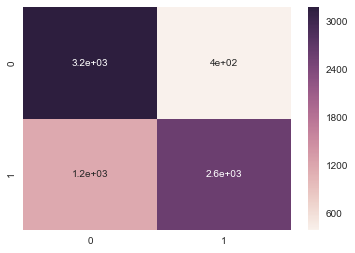

In [84]:
sb.heatmap(confusion_matrix(y,predictions),annot=True)

In [21]:
X.shape

(7395, 50)

In [27]:
import numpy as np
#ask him if have to be a matrix
Xmatric=X.as_matrix(columns=None)

In [28]:
feature_correlation_matrix=np.corrcoef(X.T)

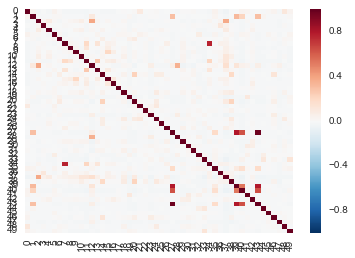

In [30]:
sb.heatmap(feature_correlation_matrix)

In [31]:
#Prepare a Range of Alpha Values to Test
alphas = np.array([100,10,1,0.1,0.01,0.001,0.0001,0])
#which hyperparmeters we want to test
# look to see what you can test with ridge
alphas

array([  1.00000000e+02,   1.00000000e+01,   1.00000000e+00,
         1.00000000e-01,   1.00000000e-02,   1.00000000e-03,
         1.00000000e-04,   0.00000000e+00])

In [32]:
model = Ridge()

In [36]:
grid = GridSearchCV(estimator=model, param_grid={'alpha': alphas,})
#a dictionary for param_grid  feed the dictionary to alpha
grid.fit(X,y)
print(grid)

## model = logistic regression  use his 

######the model set to model you want  in logistice L1, L2, c is strength of
#regular


GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+02,   1.00000e+01,   1.00000e+00,   1.00000e-01,
         1.00000e-02,   1.00000e-03,   1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [37]:
#Summarize the Results of the Grid Search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.216014564456
10.0


In [38]:
grid.best_estimator_

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [41]:
best_model=grid.best_estimator_
best_model.score(X,y)

0.22371024390947736

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=20, # Only use the top 50 most common words
)

#x=count_vectorizer.fit_transform(data.title).todense()
#This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
X = v.fit_transform(data.title).todense()
X = pd.DataFrame(X, columns=v.get_feature_names())
X.head()
#Prepare a Range of Alpha Values to Test
alphas = np.array([100,10,1,0.1,0.01,0.001,0.0001,0])
#which hyperparmeters we want to test
# look to see what you can test with ridge
alphas
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid={'alpha': alphas,})
#a dictionary for param_grid  feed the dictionary to alpha
grid.fit(X,y)
print(grid)
#Summarize the Results of the Grid Search
print(grid.best_score_)
print(grid.best_estimator_.alpha)
best_model=grid.best_estimator_
best_model.score(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+02,   1.00000e+01,   1.00000e+00,   1.00000e-01,
         1.00000e-02,   1.00000e-03,   1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
0.18423034326
1.0


0.18740866071643369

In [ ]:
#regression on data ridge   for futre use logistics

#### Using the input matrix above, fit a logistic regression model using L2 regularization
- Change the `C` parameter - how do the coefficients change? (use `examine_coeffcients`)

In [ ]:
# TODO